# Apresentação do Problema

## Contextualização

A PyCoders Ltda., cada vez mais especializada no mundo da Inteligência Artificial e Ciência de Dados, foi procurada por uma fintech para desenvolver um projeto de concessão de crédito para imóveis. Nesse projeto, espera-se a criação de valor que **discrimine ao máximo** os **bons pagadores** dos **maus pagadores**. 

Para isso, foi disponibilizada uma base de dados com milhares de casos de **empréstimos do passado** com diversas características dos clientes. 

Entrega: um modelo com a **melhor performance** possível.

Métrica de performance (inicialmente proposta): **ROC-AUC.**




---



## Base de Dados

Serão utilizadas bases de dados com **informações cadastrais, histórico de crédito e balanços financeiros de diversos clientes**. 

O conjunto de dados está dividido em **treino e teste**, todos no formato csv. 

Toda a modelagem, validação e avaliação deve ser feita em cima do conjunto de **treino**, subdividindo tal base como a squad achar melhor. 

Existe também os das variáveis explicativas, para ajudar no desenvolvimento do projeto. 

Serão necessários diversos cruzamentos e vocês estão livres para usar os dados da maneira que acharem mais conveniente.

[Clique aqui](https://drive.google.com/file/d/17fyteuN2MdGdbP5_Xq_sySN_yH91vTup/view) pra baixar os dados (eles estão disponiveis no arquivo zipado `credito-imoveis.zip`).

---
## Regras de Entrega

Deve ser entregue um arquivo csv com as **predições** para a base de teste.

Essa base deverá ser um Data Frame com duas colunas: a primeira sendo o **SK_ID_CURR** e a segunda a **probabilidade de inadimplência.**

### IMPORTANTE!

Entregar as predições com a **probabilidade da inadimplência ocorrer**, não a classe predita.

Além do arquivo com as predições, claro, entreugem também o notebook com o código utilizado. É importante que ele tenha:

- (i) a análise exploratória e construção das variáveis explicativas;

- (ii) a análise de modelagem, mostrando o processo das avaliações dos modelos e os motivos das decisões tomadas sobre qual modelo usar.

---


## Dicas


Explorar o conceito das variáveis: existe risco de imagem uma empresa utilizar variável de sexo para determinar risco de crédito? Vale a pena trazer a variável para o modelo?

Criar novas variáveis usando as variáveis que já estão na base: criatividade!

Qualquer dúvida, só me chamar! ;)



---

## Observações adicionais

- No arquivo zipado, há todas as bases que foram utilizadas na criação das bases principais (`application_{train|test_student}`). Vocês podem explorar à vontade estas outras bases pra entender como elas se comunicam entre si, e como as informações delas foram agregadas na base principal. No entanto, **não é necessário utilizar estas informações**, basta usar apenas o que tem na base de treino `application_train`. Este trabalho de cruzamento de diversas bases para a construção de uma única base de treinamento é muito importante, mas (embora já saibamos como cruzar bases!), é algo que foge do escopo deste módulo -- no módulo de banco de dados, vcs vão aprender tudo sobre isso! ;)

- Reflitam sobre isso: da forma que está, a base de teste `application_test_student` serve pra quê?

- Reforçando, pq nunca é demais: não esqueçam de fazer uma extensa análise exploratória! **Conheçam o problema com o qual vcs estão trabalhando!** Essa é a hora de botar em prática ao extremo tudo o que vimos no módulo 3 e 4! (e o que vimos no módulo 5 na etapa de modelagem, claro hehe)


---

## Alguns benchmarks

Pra ter uma ideia da performance máxima esperada do modelo, sugiro dar uma olhada nos [notebooks da competição](https://www.kaggle.com/c/home-credit-default-risk/code?competitionId=9120&sortBy=voteCount) (usem apenas como referência/inspiração! Peço que, na solução de vocês, realmente vcs apliquem as coisas como vimos no curso!!)

Em alguns notebooks, podemos ver que as AUC/ROCs máximas de validação encontradas foram de **0.76** e até mesmo **0.78** (usando modelos de gradient boosting e um pouco de feature engineering). Acredito que esse pode ser o alvo teto pra performance de vocês -- embora, como sempre dizemos: tentem chegar o mais próximo possível, no tempo que vocês têm disponível! Então, se não chegarem exatamente nessa performance, tudo bem! O importante é tentar chegar o mais próximo possível ;)

# Preparando o Ambiente

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

###############################################################

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score

##################################################################

from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn import linear_model

from sklearn.metrics import roc_curve, RocCurveDisplay

from scipy.stats import spearmanr


import pickle

%matplotlib inline

sns.set()

# Criando Funções e Utilitarios

In [2]:
def metricas_classificacao(title, estimator, X_train, X_test, y_train, y_test):
    
    # ============================================

    y_pred_train = estimator.predict(X_train)
    y_probs_train = estimator.predict_proba(X_train)[:, 1]

    ras = roc_auc_score(y_train,y_probs_train, average=None)
    
    print('\n\n')
    print("="*60)
    print(f"Métricas de avaliação de Treino: {ras:.8f}")
    print("="*60)
    
    disp = RocCurveDisplay.from_predictions(y_train, y_probs_train)
    disp.ax_.set_title(f"{title} - AUC: {roc_auc_score(y_train, y_probs_train):.3f}", fontsize=16)
    x = np.linspace(0, 1, 100)
    plt.plot(x, x, ls=":", color="black")
    plt.show()

    # ============================================

    y_pred_test = estimator.predict(X_test)
    y_probs_test = estimator.predict_proba(X_test)[:, 1]
    
    ras = roc_auc_score(y_test,y_probs_test, average=None)
    
    print('\n\n')
    print("="*60)
    print(f"Métricas de avaliação de Teste: {ras:.8f}")
    print("="*60)
    
    disp = RocCurveDisplay.from_predictions(y_test, y_probs_test)
    disp.ax_.set_title(f"{title} - AUC: {roc_auc_score(y_test, y_probs_test):.3f}", fontsize=16)
    x = np.linspace(0, 1, 100)
    plt.plot(x, x, ls=":", color="black")
    plt.show()

In [3]:
def pipe_pre_process(data, drop_not_features=None, col_target=None,
                     inputer_num_strategy="mean", encoding="onehot",
                     train_size=None, test_size=0.2):
    
    '''
    - inputer_num_strategy (str): "mean", "median";
    - encoding (str): "onehot" para OneHotEncoder; "ordinal" OrdinalEncoder;
    '''
    
    X = data.drop(columns=drop_not_features)
    y = data[col_target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, random_state=42, stratify=y)

    # ==========================================================

    pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy=inputer_num_strategy)),
                                  ("std", StandardScaler())])

    features_num = X_train.select_dtypes(include=np.number).columns.tolist()

    # ==========================================================

    if encoding == "onehot":
    
        pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                      ("onehot", OneHotEncoder(handle_unknown="ignore"))])
        
    elif encoding == "ordinal":
        
        pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                      ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value",
                                                                 unknown_value=-1))])
    
    else:
        
        raise ValueError("Únicos encodings disponíveis são 'ordinal' e 'onehot'")
        
        
    features_cat = X_train.select_dtypes(exclude=np.number).columns.tolist()

    # ==========================================================

    pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                         ("transf_cat", pipe_features_cat, features_cat)])

    return X_train, X_test, y_train, y_test, pre_processador

In [93]:
def read_tts_projeto(data, identificador, target, test_size=0.2, train_size=None):

    X = data.drop(columns=[identificador, target])
    y = data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, random_state=42, stratify=y)
    
    return X_train, X_test, y_train, y_test


In [5]:
def pipe_features_engenier(pipe_pre, X_train, X_val, X_test,
                                           inputer_num_strategy="mean",
                                           encoding="onehot",
                                           scaler=False):
    '''
    - inputer_num_strategy (str): "mean", "median";
    - encoding (str): "onehot" para OneHotEncoder; "ordinal" OrdinalEncoder;
    - scaler: "ss", "mms" ou False caso não queira scaling
    '''
    
    # getting the new features!!
    pipe_pre.fit(X_train)

    X_train = pipe_pre.transform(X_train)
    X_val = pipe_pre.transform(X_val)
    X_test = pipe_pre.transform(X_test)

    # ==========================================================
    
    passos_features_num = [("input_num", SimpleImputer(strategy=inputer_num_strategy))]
    
    # apenas se scaler não for False
    if scaler:
        
        if scaler == "ss":
            passos_features_num.append(("ss", StandardScaler()))

        elif scaler == "mms":
            passos_features_num.append(("mms", MinMaxScaler()))
            
        else:
            raise ValueError(f"Estratégia de scaling {scaler} não disponível!")
        
    pipe_features_num = Pipeline(passos_features_num)

    features_num = X_train.select_dtypes(include=np.number).columns.tolist()

    # ==========================================================

    if encoding == "onehot":
    
        pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                      ("onehot", OneHotEncoder(handle_unknown="ignore"))])
        
    elif encoding == "ordinal":
        
        pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                      ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value",
                                                                 unknown_value=-1))])
    
    else:
        
        raise ValueError("Únicos encodings disponíveis são 'ordinal' e 'onehot'")
        
        
    features_cat = X_train.select_dtypes(exclude=np.number).columns.tolist()

    # ==========================================================

    pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                         ("transf_cat", pipe_features_cat, features_cat)])

    return X_train, X_val, X_test, pre_processador



In [6]:
# Criando classes que serão utilizadas!

class FeaturesCreator(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        pass
    
    def fit(self, X, y=None):
        
        return self
    
    def fit_transform(self, X, y=None):
        
        return self
    
    def transform(self, X, y=None):
        
        X["credito_receita"] = X["AMT_CREDIT"]/X["AMT_INCOME_TOTAL"]
        X["anuidade_receita"] = X["AMT_ANNUITY"]/X["AMT_INCOME_TOTAL"]
        X["bens_receita"] = X["AMT_GOODS_PRICE"] / X["AMT_INCOME_TOTAL"]
        X["receita_pessoa"] = X["AMT_INCOME_TOTAL"] / X["CNT_FAM_MEMBERS"]

        # =======================================

        X["tempo_empregado_percent"] = np.clip(X["DAYS_EMPLOYED"] / X["DAYS_BIRTH"], 0, 1)

        # =======================================

        X["num_adultos"] = X["CNT_FAM_MEMBERS"] - X["CNT_CHILDREN"]
        X['tax_kids'] = X['CNT_CHILDREN'] / X['CNT_FAM_MEMBERS']

        # =======================================

        X['qtdd_pgtos'] = X['AMT_CREDIT'] / X['AMT_ANNUITY']

        # =======================================

        X["EXT_SOURCE_MIN"]  = X[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].min(axis = 1)
        X["EXT_SOURCE_MAX"]  = X[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].max(axis = 1)
        X["EXT_SOURCE_MEAN"] = X[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mean(axis = 1)
        X["EXT_SOURCE_SD"]   = X[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].std(axis = 1)
        X["NUM_EXT_SOURCES"] = (~X[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].isnull()).astype(int).sum(axis=1)

        # =======================================

        features_docs = [x for x in X.columns if "FLAG_DOCUMENT_" in x]
        X["NUM_DOCUMENTS"] = X[features_docs].sum(axis = 1)

        # =======================================

        X["DAY_APPR_PROCESS_START"] = X["WEEKDAY_APPR_PROCESS_START"].apply(lambda x: "Weekend" if x in ["SATURDAY", "SUNDAY"]
                                                                            else "Working day")

        # =======================================

        X["OWN_CAR_AGE_RATIO"] = X["OWN_CAR_AGE"] / X["DAYS_BIRTH"]
        X["DAYS_ID_PUBLISHED_RATIO"] = X["DAYS_ID_PUBLISH"] / X["DAYS_BIRTH"]
        X["DAYS_REGISTRATION_RATIO"] = X["DAYS_REGISTRATION"] / X["DAYS_BIRTH"]

        return X

#################################################################################

class ColumnDropper(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns_to_drop):
        
        self.columns_to_drop = columns_to_drop
        
    def fit(self, X, y=None):
        
        return self 

    def transform(self, X, y=None):
        
        return X.drop(columns = self.columns_to_drop)

In [40]:
def sv_estimator(modelo, name):    #Função para salvar os modelos apos o treino!
    
    with open(name + '.pkl', "wb") as f:
        
        pickle.dump(modelo, f)
        
def op_estimator(name):            #Função para resgatar modelos salvos.
    
    with open(name, "rb") as f:
        
        return pickle.load(f)
        
        

In [64]:
def correlacao(data, identificador, target):
    
    features = list(data.columns)
    features.remove(identificador)
    features.remove(target)
    correlacao = []
    
    for feature in features:
        
        features.remove(feature)
        
        for feature2 in features:
            coef, pvalue = spearmanr(data[feature], data[feature2])
            
            if coef > 0.8:
                
                print(tuple([feature, feature2, coef]))

    

# Importando e Analisando Dados

In [8]:
df_train = pd.read_csv("./data/application_train.csv")

df_test = pd.read_csv("./data/application_test_student.csv")


df_train.shape, df_test.shape

((246008, 122), (61503, 121))

In [9]:
df_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,456162,0,Cash loans,F,N,N,0,112500.0,700830.0,22738.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,134978,0,Cash loans,F,N,N,0,90000.0,375322.5,14422.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
2,318952,0,Cash loans,M,Y,N,0,180000.0,544491.0,16047.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,3.0
3,361264,0,Cash loans,F,N,Y,0,270000.0,814041.0,28971.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
4,260639,0,Cash loans,F,N,Y,0,144000.0,675000.0,21906.0,...,0,0,0,0,0.0,0.0,0.0,10.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246003,242114,0,Cash loans,F,N,Y,1,270000.0,1172470.5,34411.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,8.0
246004,452374,0,Cash loans,F,N,Y,0,180000.0,654498.0,27859.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
246005,276545,1,Revolving loans,M,N,N,1,112500.0,270000.0,13500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
246006,236776,1,Cash loans,M,Y,N,3,202500.0,204858.0,17653.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df_test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,149741,Cash loans,F,N,N,0,117000.0,417024.0,20191.5,360000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
1,363290,Cash loans,M,N,Y,0,450000.0,640080.0,31261.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
2,436006,Revolving loans,M,Y,Y,0,450000.0,900000.0,45000.0,900000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,0.0
3,377703,Cash loans,M,Y,N,1,360000.0,1125000.0,33025.5,1125000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,188624,Cash loans,M,Y,Y,0,675000.0,835380.0,42840.0,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61498,102817,Cash loans,M,Y,N,0,225000.0,472500.0,46161.0,454500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
61499,343961,Cash loans,M,N,Y,0,112500.0,508495.5,24592.5,454500.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0
61500,427828,Cash loans,F,Y,Y,0,157500.0,808650.0,23643.0,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
61501,405956,Cash loans,F,N,Y,0,202500.0,590337.0,30271.5,477000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246008 entries, 0 to 246007
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 229.0+ MB


In [28]:
df_train.isna().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     33172
AMT_REQ_CREDIT_BUREAU_WEEK    33172
AMT_REQ_CREDIT_BUREAU_MON     33172
AMT_REQ_CREDIT_BUREAU_QRT     33172
AMT_REQ_CREDIT_BUREAU_YEAR    33172
Length: 122, dtype: int64

------

Visualização do valor do emprestimo versus a renda total do cliente

No eixo Y temos a feature "AMT_INCOME_TOTAL", o valor total da renda do cliente

No eixo X temos a feature "AMT_CREDIT", o valor do credito do emprestimo


Em laranja os clientes que apresentaram alguma dificuladade no pagamento do emprestimo.

Não há relação direta da renda do cliente em relação ao valor solicitado.

Wall time: 470 ms


<AxesSubplot:xlabel='AMT_CREDIT', ylabel='AMT_INCOME_TOTAL'>

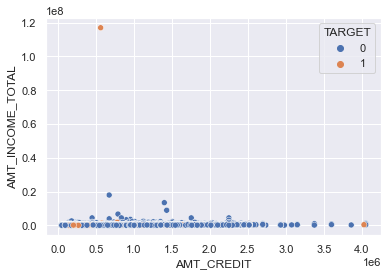

In [33]:
%%time

sns.scatterplot(data=df_train, x='AMT_CREDIT', y="AMT_INCOME_TOTAL", hue="TARGET", )

-----------

Grafico do valor do Emprestimo versus o valor do Imovel

No eixo X a feature "AMT_CREDIT", valor do emprestimo

No eixo Y a feature "AMT_GOODS_PRICE", valor do bem a ser financiado

Há uma relação direta do valor do imovel ao do emprestimo!

Wall time: 411 ms


<AxesSubplot:xlabel='AMT_CREDIT', ylabel='AMT_GOODS_PRICE'>

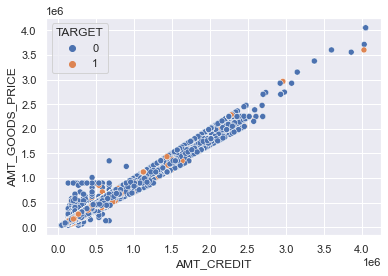

In [39]:
%%time

sns.scatterplot(data=df_train, x='AMT_CREDIT', y="AMT_GOODS_PRICE", hue="TARGET", )

# Modelagem Basica

Iremos fazer uma modelagem basica com os dados numericos, iremos desconciderar os dados categoricos.

Utilizaremos como estimador o Logistic Regression, veremos qual estimativa de ROC-AUC iremos receber.

In [41]:
%%time

df_model_baseline = df_train.select_dtypes(include=np.number).dropna(axis=1)

df_model_baseline

Wall time: 287 ms


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,456162,0,0,112500.0,700830.0,0.019689,-8676,-813,-4163.0,-1363,...,0,0,0,0,0,0,0,0,0,0
1,134978,0,0,90000.0,375322.5,0.025164,-13583,-223,-3554.0,-3287,...,0,0,0,0,0,0,0,0,0,0
2,318952,0,0,180000.0,544491.0,0.035792,-13993,-6202,-7971.0,-4175,...,0,0,0,0,0,0,0,0,0,0
3,361264,0,0,270000.0,814041.0,0.046220,-22425,365243,-11805.0,-1732,...,0,0,0,0,0,0,0,0,0,0
4,260639,0,0,144000.0,675000.0,0.026392,-18839,-2763,-5069.0,-2381,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246003,242114,0,1,270000.0,1172470.5,0.035792,-15992,-4333,-10024.0,-4089,...,0,0,0,0,0,0,0,0,0,0
246004,452374,0,0,180000.0,654498.0,0.003122,-23798,365243,-3734.0,-4637,...,0,0,0,0,0,0,0,0,0,0
246005,276545,1,1,112500.0,270000.0,0.011657,-14793,-1982,-7629.0,-4453,...,0,0,0,0,0,0,0,0,0,0
246006,236776,1,3,202500.0,204858.0,0.016612,-14418,-2840,-1900.0,-4443,...,0,0,0,0,0,0,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.7s finished



Métricas de avaliação de Treino: 0.59861905


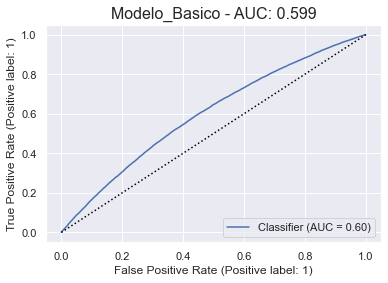




Métricas de avaliação de Teste: 0.59040761


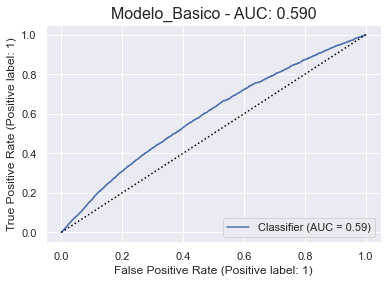

Wall time: 13.4 s


In [37]:
%%time

X = df_model_baseline.drop(columns=["TARGET", "SK_ID_CURR"])
y = df_model_baseline["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

dados_split = (X_train, X_test, y_train, y_test)

lr_baseline = LogisticRegression(n_jobs=-1, verbose=100).fit(X_train, y_train)

sv_estimator(modelo= lr_baseline, name='Modelo_Basico1')

metricas_classificacao("Modelo_Basico", lr_baseline, *dados_split)

----------
Para analise iremos retirar augumas features numericas que tem forte correlação (correlação superior a 0.8), com a intencao de ver se a variacao da metrica é sensivel, visto a perda de informação

In [65]:
%%time

correlacao(df_model_baseline,'SK_ID_CURR', 'TARGET')

('REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 0.9499984257285994)
('REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 0.8598479133404736)
('LIVE_CITY_NOT_WORK_CITY', 'REG_CITY_NOT_WORK_CITY', 0.8255979919262306)
Wall time: 30.6 s


In [77]:
df_model_baseline["LIVE_CITY_NOT_WORK_CITY"].unique()

array([0, 1], dtype=int64)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.8s finished



Métricas de avaliação de Treino: 0.59861904


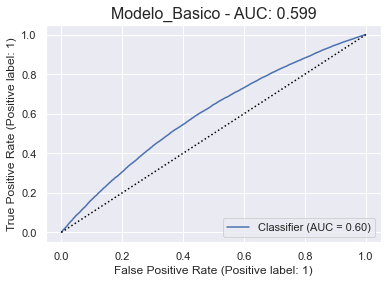




Métricas de avaliação de Teste: 0.59040766


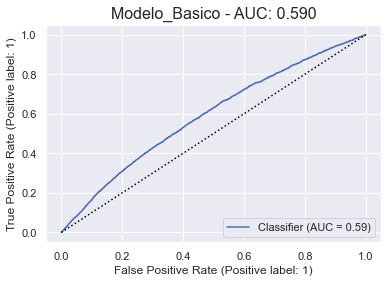

Wall time: 12.2 s


In [80]:
%%time

drop = ["TARGET", "SK_ID_CURR", "REGION_RATING_CLIENT_W_CITY", "LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_WORK_CITY"]

X = df_model_baseline.drop(columns=drop)
y = df_model_baseline["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

dados_split = (X_train, X_test, y_train, y_test)

lr_baseline = LogisticRegression(n_jobs=-1, verbose=100).fit(X_train, y_train)

sv_estimator(modelo= lr_baseline, name='Modelo_Basico1')

metricas_classificacao("Modelo_Basico", lr_baseline, *dados_split)

# Testando Modelos Avançados

Testando modelos mais completos e complexos, utilizaremos os seguintes modelos

- Logistic Regression

- Randon Forest Classifier

- Gradient Boosting Classifier

- SVC

Utilizaremos a base de dados completos, com as features categoricas tambem.

Porem para agilizar o processo utilizaremos 10% da base (24.600 linhas) para trinar o modelo, e utilizaremos 3% da base (7.381 linhas) para testes de performance.

## Ajustando Dados

iremos preparar a base de dados, escalar as features,

In [84]:
drop = ['TARGET', 'SK_ID_CURR']

X_train, X_test, y_train, y_test, pre_processador = pipe_pre_process(df_train, drop_not_features=drop,
                                                                     col_target="TARGET", inputer_num_strategy="mean",
                                                                     encoding="onehot", train_size=0.1, test_size=0.03)


dados_split = (X_train, X_test, y_train, y_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24600, 120), (7381, 120), (24600,), (7381,))

## Avaliando Modelos

Iresmos testar o desempenho dos modelos com a base de dados, iremos transformamos as features categoricas para o formato "onehot"

Iremos avaliar o desempenho do Logistic Regression, percebemos que ao adicionar os dados categoricos a performace dele já superou o modelo basico.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.5s finished



Métricas de avaliação de Treino: 0.75357767


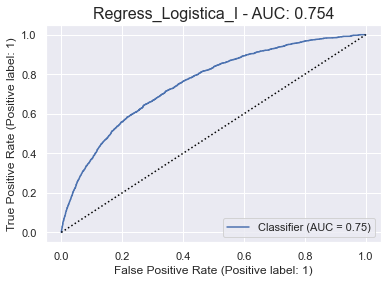




Métricas de avaliação de Teste: 0.71844601


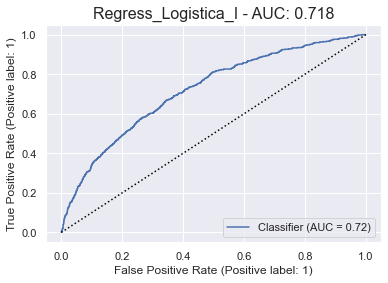

Wall time: 10.9 s


In [86]:
%%time

pipe_rl = Pipeline([("pre_processador", pre_processador),
                     ("rl", LogisticRegression(random_state=42, n_jobs=-1, verbose=100))])

pipe_rl.fit(X_train, y_train)

sv_estimator(pipe_rl, "Regress_Logistica_I")

metricas_classificacao("Regress_Logistica_I", pipe_rl, *dados_split)

----

Ja o Random Forest Classifier overfitou nos dados de treino e mas teve um desempenho superior ao modelo basico na avaliação de teste.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s

building tree 10 of 100[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s

building tree 11 of 100building tree 12 of 100[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.1s

[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s

building tree 13 of 100[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s

building tree 14 of 100
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.1s
building tree 15 of 100[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.1s

building tree 16 of 100[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s

building tree 17 of 100[Parallel(n_jobs=-1)]: Do

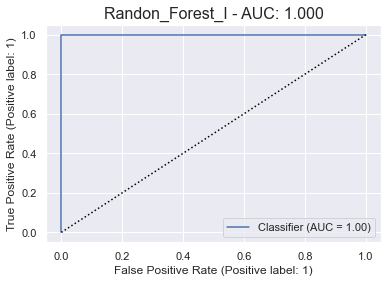

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    0.0s
[Para

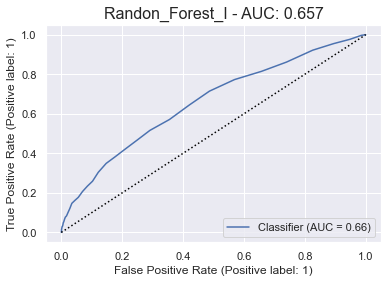

Wall time: 4.16 s


In [87]:
%%time

pipe_rf = Pipeline([("pre_processador", pre_processador),
                     ("rf", RandomForestClassifier(random_state=42, n_jobs=-1, verbose=100))])

pipe_rf.fit(X_train, y_train)

sv_estimator(pipe_rf, "Randon_Forest_I")

metricas_classificacao("Randon_Forest_I", pipe_rf, *dados_split)

------

O Gradient Boosting Classifier teve um bom desempenho no trein e classificação, alem disso ele não aparenta estar overfitado.

      Iter       Train Loss   Remaining Time 
         1           0.5540           31.27s
         2           0.5470           30.08s
         3           0.5416           29.69s
         4           0.5372           29.72s
         5           0.5335           29.24s
         6           0.5301           28.83s
         7           0.5275           28.56s
         8           0.5251           28.24s
         9           0.5230           27.96s
        10           0.5213           27.62s
        11           0.5194           27.27s
        12           0.5178           27.02s
        13           0.5164           26.65s
        14           0.5149           26.30s
        15           0.5136           25.98s
        16           0.5125           25.63s
        17           0.5114           25.32s
        18           0.5102           25.01s
        19           0.5090           24.71s
        20           0.5082           24.41s
        21           0.5071           24.12s
        2

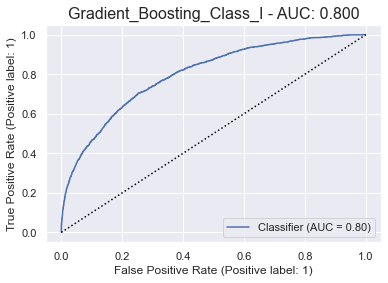




Métricas de avaliação de Teste: 0.72119499


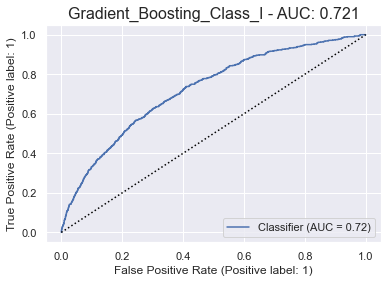

Wall time: 33.2 s


In [89]:
%%time

pipe_gb = Pipeline([("pre_processador", pre_processador),
                     ("gb", GradientBoostingClassifier(random_state=42, verbose=100))])

pipe_gb.fit(X_train, y_train)

sv_estimator(modelo=pipe_gb, name="Gradient_Boosting_Class_I")

metricas_classificacao("Gradient_Boosting_Class_I", pipe_gb, *dados_split)

---------

O SVC aparentemente overfitou no treino. pois seu desempenho foi muito inferior no teste.

[LibSVM]


Métricas de avaliação de Treino: 0.97206430


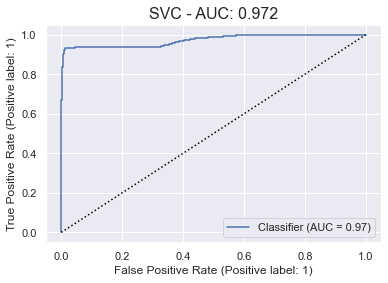




Métricas de avaliação de Teste: 0.60961870


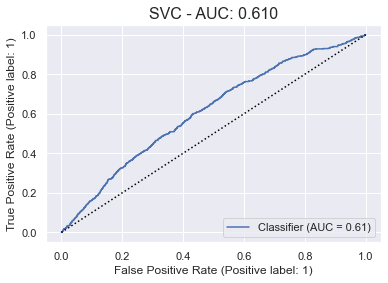

Wall time: 14min 27s


In [90]:
%%time

pipe_svc = Pipeline([("pre_processador", pre_processador),
                     ("svc", SVC(random_state=42, verbose=100, probability=True))])

pipe_svc.fit(X_train, y_train)
    
sv_estimator(modelo=pipe_svc, name='SVC')

metricas_classificacao("SVC", pipe_svc, *dados_split)

## Feature Engineering & Undersampling

Iremos modificar a base criando features que podem melhorar o desempenho dos modelos.

In [94]:
%%time


X_train, X_val, y_train, y_val = read_tts_projeto(df_train, identificador="SK_ID_CURR", target="TARGET",
                                                 test_size=0.1, train_size=0.03)

X_test = df_test.drop(columns=["SK_ID_CURR"])
y_test = df_test["SK_ID_CURR"]


drop = ["CODE_GENDER"]

pipe_pre = Pipeline([("creat_surname", FeaturesCreator()),
                    ("column_dropper", ColumnDropper(drop))])

X_train, X_val, X_test, pre_processador = pipe_features_engenier(pipe_pre, X_train, X_val, X_test,
                                                                inputer_num_strategy="mean",
                                                                encoding="onehot", scaler="ss")

dados_split = (X_train, X_val, y_train, y_val)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

Wall time: 652 ms


((7380, 137), (24601, 137), (61503, 137), (7380,), (24601,), (61503,))

## Avaliando Modelos após a Feature Engineering

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s finished



Métricas de avaliação de Treino: 0.78062686


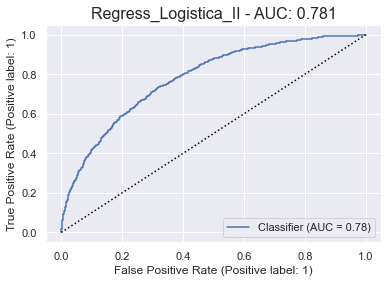




Métricas de avaliação de Teste: 0.70859366


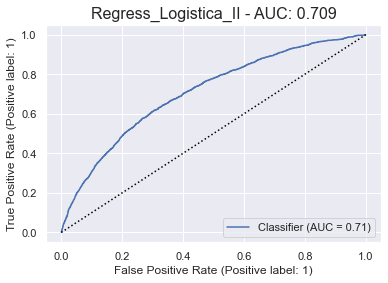

Wall time: 4.56 s


In [96]:
%%time

pipe_rl = Pipeline([("pre_processador", pre_processador),
                   ("Lr", LogisticRegression(random_state=42, n_jobs=-1, verbose=100))])


pipe_rl.fit(X_train, y_train)

sv_estimator(pipe_rl, "Regress_Logistica_II")

metricas_classificacao("Regress_Logistica_II", pipe_rl, *dados_split)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100building tree 6 of 100

building tree 7 of 100
building tree 8 of 100
building tree 9 of 100[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s

building tree 10 of 100[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s

building tree 11 of 100[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s

building tree 12 of 100[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s

building tree 13 of 100[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
building tree 14 of 100[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.0s


building tree 15 of 100[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.0s

building tree 16 of 100
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
building tree 17 of 100[Parallel(n_jobs=-1)]: Do

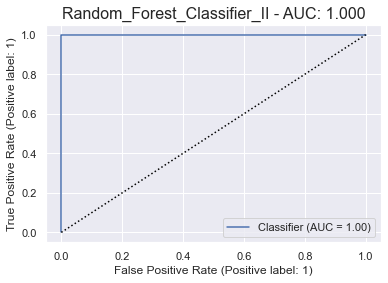

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    0.0s
[Para

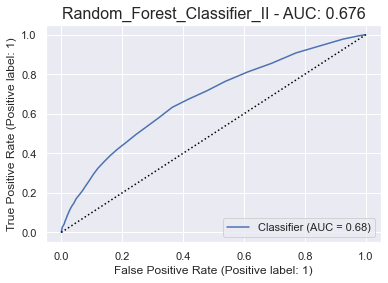

Wall time: 2.81 s


In [97]:
%%time

pipe_rf = Pipeline([("pre_processador", pre_processador),
                   ("Rf", RandomForestClassifier(random_state=42, n_jobs=-1, verbose=100))])


pipe_rf.fit(X_train, y_train)

sv_estimator(pipe_rf, "Random_Forest_Classifier_II")

metricas_classificacao("Random_Forest_Classifier_II", pipe_rf, *dados_split)

      Iter       Train Loss   Remaining Time 
         1           0.5507            9.38s
         2           0.5411            9.72s
         3           0.5339            9.80s
         4           0.5280            9.57s
         5           0.5222            9.41s
         6           0.5179            9.34s
         7           0.5140            9.20s
         8           0.5107            9.08s
         9           0.5080            9.08s
        10           0.5048            8.96s
        11           0.5021            8.84s
        12           0.5001            8.80s
        13           0.4984            8.69s
        14           0.4958            8.61s
        15           0.4936            8.52s
        16           0.4901            8.41s
        17           0.4886            8.31s
        18           0.4868            8.24s
        19           0.4854            8.11s
        20           0.4838            8.02s
        21           0.4827            7.95s
        2

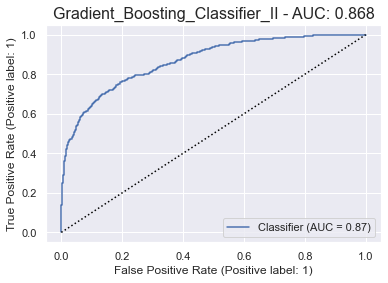




Métricas de avaliação de Teste: 0.71804971


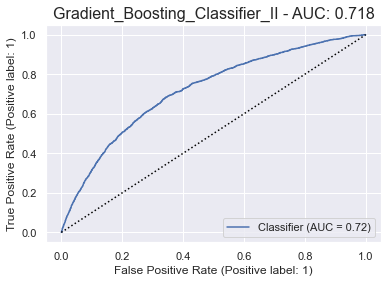

Wall time: 12.6 s


In [98]:
%%time

pipe_gb = Pipeline([("pre_processador", pre_processador),
                   ("Gb", GradientBoostingClassifier(random_state=42, verbose=100))])


pipe_gb.fit(X_train, y_train)

sv_estimator(pipe_gb, "Gradient_Boosting_Classifier_II")

metricas_classificacao("Gradient_Boosting_Classifier_II", pipe_gb, *dados_split)

[LibSVM]


Métricas de avaliação de Treino: 0.98040730


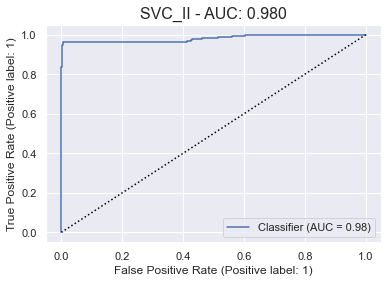




Métricas de avaliação de Teste: 0.60547852


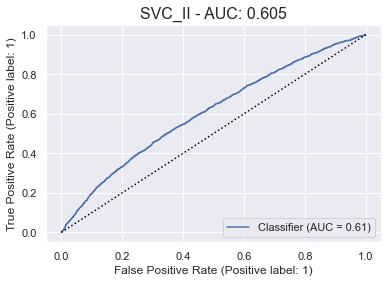

Wall time: 1min 18s


In [100]:
%%time

pipe_svc = Pipeline([("pre_processador", pre_processador),
                   ("SVC", SVC(random_state=42, verbose=100, probability=True))])


pipe_svc.fit(X_train, y_train)

sv_estimator(pipe_svc, "SVC_II")

metricas_classificacao("SVC_II", pipe_svc, *dados_split)

# Melhores Modelos

Os modelos que apresentarem melhor desempenho e generalização foram Logistic Regression e Gradient Boosting Classifier

Iremos utilizar o Grid para testarmos as melhores combinações de hiperparametros e iremos balancear a base.

## Preparando Dados

Escalando e equilibrando a base.

In [101]:
X_train, X_val, y_train, y_val = read_tts_projeto(df_train, identificador="SK_ID_CURR", target="TARGET")

X_test = df_test.drop(columns=["SK_ID_CURR"])
y_test = df_test["SK_ID_CURR"]

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((196806, 120), (49202, 120), (61503, 120), (196806,), (49202,), (61503,))

In [102]:
drop = ["CODE_GENDER"]

pipe_pre = Pipeline([("creat_surname", FeaturesCreator()),
                    ("column_dropper", ColumnDropper(drop))])

X_train, X_val, X_test, pre_processador = pipe_features_engenier(pipe_pre, X_train, X_val, X_test,
                                                                inputer_num_strategy="mean",
                                                                encoding="onehot", scaler="ss")

dados_split = (X_train, X_val, y_train, y_val)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((196806, 137), (49202, 137), (196806,), (49202,))

## Avaliando os Modelos

Iremos verificar os dois modelos que tiveram um melhor desempenho.

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\maid\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
75 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\maid\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\maid\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "C:\Users\maid\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, s

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
max_iter reached after 13 seconds
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.2s finished

Best params:{'rl__C': 0.5, 'rl__penalty': 'l2', 'rl__solver': 'sag'}



C:\Users\maid\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(





Métricas de avaliação de Treino: 0.74218792


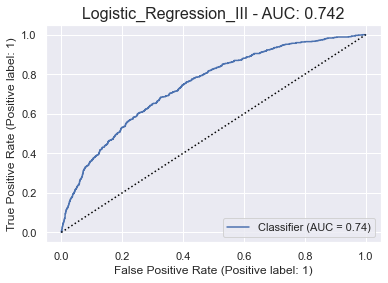




Métricas de avaliação de Teste: 0.74123732


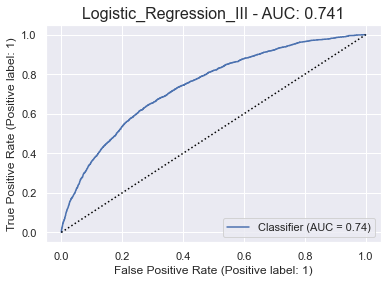

Wall time: 11min 57s


In [104]:
%%time

pipe_rl = Pipeline([("under_samp", RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
                   ("pre_processador", pre_processador),
                   ("rl", LogisticRegression(random_state=42, n_jobs=-1, verbose=100))])

param_grid_rl = {"rl__penalty" : ["l1", "l2", 'elasticnet', "none"],
                 "rl__C" : [0.5, 0.8, 1],
                 "rl__solver" : ['liblinear', 'sag', 'saga']}

splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_rl = GridSearchCV(estimator=pipe_rl, param_grid=param_grid_rl,
                        scoring="roc_auc", cv=splitter,
                        verbose=100, n_jobs=-1)

grid_rl.fit(X_train, y_train)

print("="*100)
print(f"\nBest params:{grid_rl.best_params_}\n")
print("="*100)

sv_estimator(modelo=grid_rl, name="Logistic_Regression_III")

metricas_classificacao("Logistic_Regression_III", grid_rl, *dados_split)

Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best params:{'gb__loss': 'exponential', 'gb__max_depth': 3, 'gb__n_estimators': 500}




Métricas de avaliação de Treino: 0.78601902


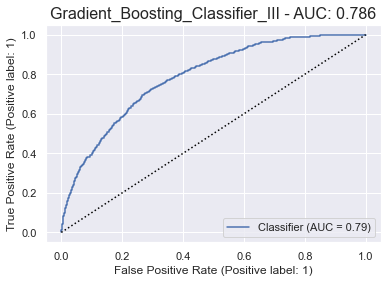




Métricas de avaliação de Teste: 0.78929343


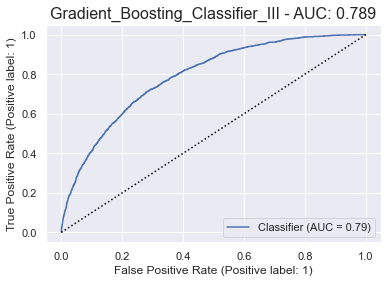

Wall time: 3h 56min 32s


In [105]:
%%time

pipe_gb = Pipeline([("under_samp", RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
                   ("pre_processador", pre_processador),
                   ("gb", GradientBoostingClassifier(random_state=42))])

param_grid_gb = {"gb__loss" : ["deviance", "exponential"],
                 "gb__n_estimators" : np.arange(5, 8)*100,
                 "gb__max_depth" : range(2, 5)}

splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_gb = GridSearchCV(estimator=pipe_gb, param_grid=param_grid_gb,
                        scoring="roc_auc", cv=splitter,
                        verbose=100, n_jobs=-1)

grid_gb.fit(X_train, y_train)

print("="*100)
print(f"\nBest params:{grid_gb.best_params_}\n")
print("="*100)

sv_estimator(modelo=grid_gb, name="Gradient_Boosting_Classifier_III")

metricas_classificacao("Gradient_Boosting_Classifier_III", grid_gb, *dados_split)

# Melhor Estimador

In [109]:
%%time

y = grid_gb.predict_proba(X_test)

df_prev = pd.Series(y[:,-1], index=df_test['SK_ID_CURR'], name='TARGET')

arquivo = '/content/drive/MyDrive/Colab Notebooks/Data Scienc Degree/05 - Machine Learning/Projeto_IV/'

df_prev.to_csv('Predct_Projeto_ML', header=True)

Wall time: 1.7 s
